# B. Classification Modelling

**In brief, we are going to tackle the classification problem "Severity of Aircraft Accident in the US based on Top Ten Aircraft Manufacturers" using Random Forest, Logistic Regression, and Neural Network.**

Before an accident happened, we want to predict whether such accident will result in "Negligible"  or "Catastrophic" risk, based on the variables we kept in the previous notebook.

There are several steps that we will undergo are: 
>1. One-Hot Encoding Categorical Variable
>2. Train-Test Split
>3. Fitting & Scoring Models: Random Forest and Neural Network

Other known encoding method is mean encoding. For this project, let's focus on one-hot-encoding!

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

In [2]:
df = pd.read_csv("selected_df.csv")
df.head()

,Year,Seasons,Division,Make,Number.of.Engines,Engine.Type,Purpose.of.Flight,Weather.Condition,Broad.Phase.of.Flight,Injury.Severity
0,2019,Winter,FWST,Cessna,1.0,1,Personal,VMC,TAKEOFF,0
1,2019,Winter,PLNS,Mooney,1.0,1,Personal,VMC,TAKEOFF,1
2,2019,Winter,SEST,Piper,2.0,0,Others,IMC,TAKEOFF,1
3,2019,Winter,GRLK,Cessna,1.0,1,Instructional,VMC,LANDING,0
4,2019,Winter,FWST,Cessna,1.0,1,Personal,VMC,CRUISE,0


In [3]:
print("Data Dims:", df.shape)
print("Data Types:")
print(df.dtypes)

Data Dims: (50144, 10)
Data Types:
Year                       int64
Seasons                   object
Division                  object
Make                      object
Number.of.Engines        float64
Engine.Type                int64
Purpose.of.Flight         object
Weather.Condition         object
Broad.Phase.of.Flight     object
Injury.Severity            int64
dtype: object


## 1. One-Hot Encoding

We need to transform categorical variables into numerical variable ('1' or '0' matrixes) using `pd.get_dummies`

`Number of Engines` is a categorical variable, yet its data type is float. We need to tweak this.

In [4]:
#First we change the categories from float into strings first
engine_dict = {0.0:"Zero", 1.0:"One",2.0:"Two",3.0:"Three",4.0:"Four"}
df["Number.of.Engines"] = df["Number.of.Engines"].map(engine_dict)

df["Number.of.Engines"].unique()

array(['One', 'Two', 'Four', 'Three', 'Zero'], dtype=object)

### a. Encoding categorical variables in `Seasons`, `Division`, `Make`, `#Engine`, `Purpose`, `Weather`, and `Phase`

In [5]:
features = ["Seasons","Division","Make","Number.of.Engines","Purpose.of.Flight",\
            "Weather.Condition","Broad.Phase.of.Flight"]

for feature in features:
    temp = pd.get_dummies(df[feature])
    df = pd.concat([df,temp],axis=1,join="inner")

print("Data Dims:", df.shape)

df.head()

Data Dims: (50144, 54)


,Year,Seasons,Division,Make,Number.of.Engines,Engine.Type,Purpose.of.Flight,Weather.Condition,Broad.Phase.of.Flight,Injury.Severity,...,CLIMB,CRUISE,DESCENT,GO-AROUND,LANDING,MANEUVERING,OTHERS,STANDING,TAKEOFF,TAXI
0,2019,Winter,FWST,Cessna,One,1,Personal,VMC,TAKEOFF,0,...,0,0,0,0,0,0,0,0,1,0
1,2019,Winter,PLNS,Mooney,One,1,Personal,VMC,TAKEOFF,1,...,0,0,0,0,0,0,0,0,1,0
2,2019,Winter,SEST,Piper,Two,0,Others,IMC,TAKEOFF,1,...,0,0,0,0,0,0,0,0,1,0
3,2019,Winter,GRLK,Cessna,One,1,Instructional,VMC,LANDING,0,...,0,0,0,0,1,0,0,0,0,0
4,2019,Winter,FWST,Cessna,One,1,Personal,VMC,CRUISE,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
df.columns

Index(['Year', 'Seasons', 'Division', 'Make', 'Number.of.Engines',
       'Engine.Type', 'Purpose.of.Flight', 'Weather.Condition',
       'Broad.Phase.of.Flight', 'Injury.Severity', 'Fall', 'Spring', 'Summer',
       'Winter', 'FWST', 'GRLK', 'MEST', 'NWED', 'PLNS', 'RMTN', 'SEST',
       'SWST', 'Air Tractor', 'Beech', 'Bell', 'Boeing', 'Cessna', 'Grumman',
       'Hughes', 'Mooney', 'Piper', 'Robinson', 'Four', 'One', 'Three', 'Two',
       'Zero', 'Instructional', 'Others', 'Personal', 'IMC', 'UNK', 'VMC',
       'APPROACH', 'CLIMB', 'CRUISE', 'DESCENT', 'GO-AROUND', 'LANDING',
       'MANEUVERING', 'OTHERS', 'STANDING', 'TAKEOFF', 'TAXI'],
      dtype='object')

Now we were done in creating a '1' and '0' matrixes for every categorical features in our cleaned dataset.

### b. Avoiding dummy variable trap

For each categorical features, we need to remove one dummy variable so that the machine won't confuse itself. Note that some models may be able to avoid this trap without the need of dropping one dummy variable from each categorical feature, but it is always a good practice to do so!

In [7]:
to_remove = ["Winter","PLNS","Robinson","Zero","Others","UNK","OTHERS"]

df.drop(to_remove, axis=1, inplace=True)

print("New Data Dims:", df.shape)

New Data Dims: (50144, 47)


### c. Dropping the remaining columns

Since we have created dummy variables to replace the initial categorical variables, we can simply remove them. 

In [8]:
to_remove = ["Seasons","Division","Make","Number.of.Engines","Engine.Type","Purpose.of.Flight",\
           "Weather.Condition","Broad.Phase.of.Flight"]

df.drop(to_remove, axis=1, inplace=True)

print("New Data Dims:", df.shape)

df.head()

New Data Dims: (50144, 39)


,Year,Injury.Severity,Fall,Spring,Summer,FWST,GRLK,MEST,NWED,RMTN,...,APPROACH,CLIMB,CRUISE,DESCENT,GO-AROUND,LANDING,MANEUVERING,STANDING,TAKEOFF,TAXI
0,2019,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2019,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2019,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2019,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## 2. Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

Splitting the `Train` and `Test` data with test size = 25%

In [10]:
X = df.drop(["Injury.Severity"],axis = 1) 
y = df["Injury.Severity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=21)
print("X train dims:", X_train.shape)
print("X test dims:", X_test.shape)
print("y train dims:", y_train.shape[0])
print("y test dims:", y_test.shape[0])

X train dims: (37608, 38)
X test dims: (12536, 38)
y train dims: 37608
y test dims: 12536


**Note:** We can also implement k-fold cross validation and get the mean of their respective scores. However, for this experimental purpose, let's keep it simple.

## 3. Model Fitting and Scoring

In [11]:
#To store our model results
model_result = []

### a. Random Forest Classification

In [12]:
from sklearn.ensemble import RandomForestClassifier

#### i. Tuning the optimum `number of estimators`

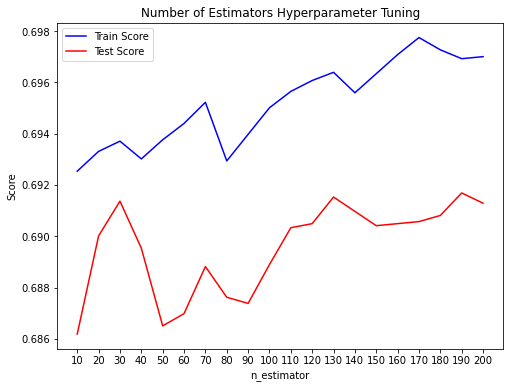

In [13]:
def rfc(X_train,X_test,y_train,y_test,n_list):
    
    result = []
    
    for param in n_list:
        clf = RandomForestClassifier(n_estimators=param, max_depth = 8, random_state=0)
        model = clf.fit(X_train, y_train)
        result.append([param, model.score(X_train,y_train), model.score(X_test,y_test)])
        
    result = pd.DataFrame(result,columns=["n_estimator","train_score","test_score"])
        
    return result

#Performing parameter search
rfc_pred = rfc(X_train,X_test,y_train,y_test,[x for x in range(10,201,10)])

#Plotting the curves for train score and test score against the n estimators of random forest trees
f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(rfc_pred["n_estimator"], rfc_pred["train_score"], color="blue")  #train score
ax.plot(rfc_pred["n_estimator"], rfc_pred["test_score"], color ="red")   #test score
ax.set_title('Number of Estimators Hyperparameter Tuning')
ax.set_xlabel("n_estimator")
ax.set_ylabel("Score")
ax.legend(["Train Score","Test Score"])

#x_ticks
start = 10
end = 200
ax.xaxis.set_ticks(np.arange(start, end+1, 10))

In [14]:
rfc_pred[rfc_pred.n_estimator==190]

,n_estimator,train_score,test_score
18,190,0.696926,0.691688


**Note** n_estimator = 190 has the best test performance. We will use this value to tune the maximum depth.

#### ii. Tuning the optimum `max depth`

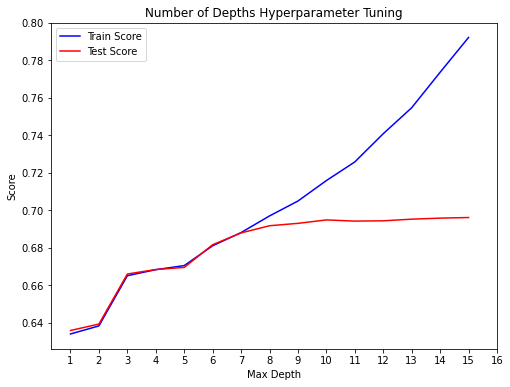

In [15]:
def rfc(X_train,X_test,y_train,y_test,depth_list):
    
    result = []
    
    for param in depth_list:
        clf = RandomForestClassifier(n_estimators=190, max_depth = param, random_state=0)
        model = clf.fit(X_train, y_train)
        result.append([param, model.score(X_train,y_train), model.score(X_test,y_test)])
        
    result = pd.DataFrame(result,columns=["max_depth","train_score","test_score"])
        
    return result

#Performing parameter search
rfc_pred = rfc(X_train,X_test,y_train,y_test,[x for x in range(1,16)])

#Plotting the curves for train score and test score against the max depth of random forest trees
f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(rfc_pred["max_depth"], rfc_pred["train_score"], color="blue")   #train score
ax.plot(rfc_pred["max_depth"], rfc_pred["test_score"], color ="red")   #test score
ax.set_title('Number of Depths Hyperparameter Tuning')
ax.set_xlabel("Max Depth")
ax.set_ylabel("Score")
ax.legend(["Train Score","Test Score"])

#x_ticks
start = 1
end = 16
ax.xaxis.set_ticks(np.arange(start, end+1, 1))

In [16]:
rfc_pred[rfc_pred.max_depth.isin([x for x in range(10,16)])]

,max_depth,train_score,test_score
9,10,0.715805,0.694799
10,11,0.725750,0.694161
11,12,0.740826,0.694320
12,13,0.754680,0.695198
13,14,0.773612,0.695756
14,15,0.792198,0.696075


The performance of test score plateaued at max depth > 10 and peaked at max_depth = 15. At this depth, train score is 79.2% and test score is 69.6%. We will use this max depth value.

#### iii. Tuning `min sample split`

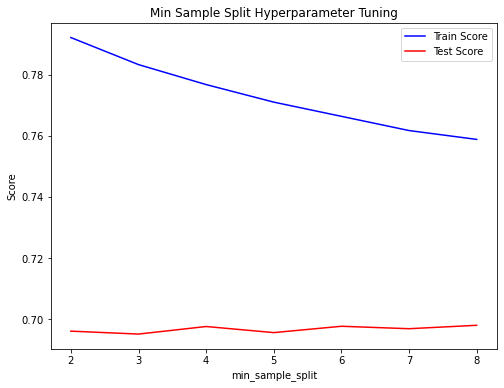

In [17]:
def rfc(X_train,X_test,y_train,y_test,min_sample_split):
    
    result = []
    
    for param in min_sample_split:
        clf = RandomForestClassifier(n_estimators=190, max_depth = 15, min_samples_split = param, random_state=0)
        model = clf.fit(X_train, y_train)
        result.append([param, model.score(X_train,y_train), model.score(X_test,y_test)])
        
    result = pd.DataFrame(result,columns=["min_split","train_score","test_score"])
        
    return result

#Performing parameter search
rfc_pred = rfc(X_train,X_test,y_train,y_test,[x for x in range(2,9)])

#Plotting the curves for train score and test score against the min sample split of random forest trees
f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(rfc_pred["min_split"], rfc_pred["train_score"], color="blue")  #train score
ax.plot(rfc_pred["min_split"], rfc_pred["test_score"], color ="red")   #test score
ax.set_title('Min Sample Split Hyperparameter Tuning')
ax.set_xlabel("min_sample_split")
ax.set_ylabel("Score")
ax.legend(["Train Score","Test Score"])

#x_ticks
start = 2
end = 8
ax.xaxis.set_ticks(np.arange(start, end+1, 1))

In [18]:
rfc_pred[rfc_pred.min_split.isin([4,6,8])]

,min_split,train_score,test_score
2,4,0.776803,0.697591
4,6,0.766406,0.697671
6,8,0.758854,0.697990


Since test score for min_samples_split = 4, 6, and 8 are similar, we pick the one with higher train_score, which is 4

#### iv. Tuning `min sample leaf`

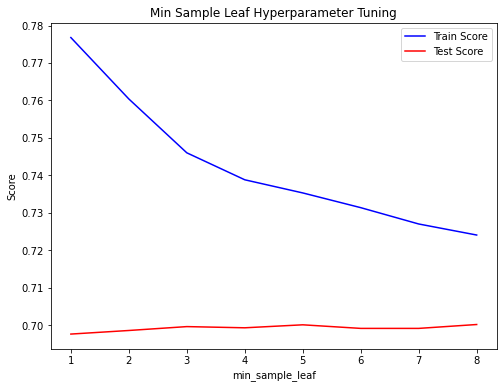

In [19]:
def rfc(X_train,X_test,y_train,y_test,min_sample_leaf):
    
    result = []
    
    for param in min_sample_leaf:
        clf = RandomForestClassifier(n_estimators=190, max_depth = 15, min_samples_split = 4, \
                                    min_samples_leaf = param, random_state=0)
        model = clf.fit(X_train, y_train)
        result.append([param, model.score(X_train,y_train), model.score(X_test,y_test)])
        
    result = pd.DataFrame(result,columns=["min_leaf","train_score","test_score"])
        
    return result

#Performing parameter search
rfc_pred = rfc(X_train,X_test,y_train,y_test,[x for x in range(1,9)])

#Plotting the curves for train score and test score against the min sample leaf of random forest trees
f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(rfc_pred["min_leaf"], rfc_pred["train_score"], color="blue")  #train score
ax.plot(rfc_pred["min_leaf"], rfc_pred["test_score"], color ="red")   #test score
ax.set_title('Min Sample Leaf Hyperparameter Tuning')
ax.set_xlabel("min_sample_leaf")
ax.set_ylabel("Score")
ax.legend(["Train Score","Test Score"])

#x_ticks
start = 1
end = 8
ax.xaxis.set_ticks(np.arange(start, end+1, 1))

In [20]:
rfc_pred[rfc_pred.min_leaf.isin([1,8])]

,min_leaf,train_score,test_score
0,1,0.776803,0.697591
7,8,0.724048,0.700144


Test scores for min_samples_leaf = 8 is better. We will pick this.

Overall, our random forest model parameters will be `n_estimator` = 190, `max_depth` = 15, `min_samples_split` = 4, and `min_samples_leaf` = 8.

In [21]:
#Assigning the parameters into the final model
clf = RandomForestClassifier(n_estimators=190, max_depth = 15, min_samples_split = 4, min_samples_leaf = 8)
model_rfc = clf.fit(X_train, y_train)
print("Train score:",model_rfc.score(X_train,y_train))
print("Test score:",model_rfc.score(X_test,y_test))

Train score: 0.7247394171452882
Test score: 0.6991065730695597


Good! Our benchmark random forest model has 72.5% and 69.9% train and test score, respectively.

#### v. Confusion Matrix and F1 Scoring

F1 = 2(Precision x Recall)/(Precision + Recall)

with Precision = TP/(TP+FP) and Recall = TP/(TP+FN)

Precision is how precise the predicted positive with the actual.
Recall is how good the model captures actual positives. 

Note: Accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

<AxesSubplot:>

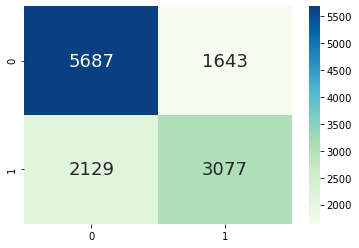

In [23]:
y_test_pred = model_rfc.predict(X_test)

sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},cmap = "GnBu")

In [24]:
f1_score(y_test,y_test_pred,average="weighted")

0.6965678387509049

In [25]:
#Saving our model
pickle.dump(model_rfc, open("rfc_model.sav",'wb'))

model_result.append(["RFC",model_rfc.score(X_train,y_train),model_rfc.score(X_test,y_test),\
                     f1_score(y_test,y_test_pred,average="weighted")])

### B. Logistic Regression

Logistic Regression is basically a one-layer neural network. It is important to figure out the benchmark logistic regression scores before proceeding into the unsupervised neural network itself.

In [26]:
from sklearn.linear_model import LogisticRegression

#### i. Tuning `solver`

C:\Users\MIKE\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\MIKE\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\MIKE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\MIKE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


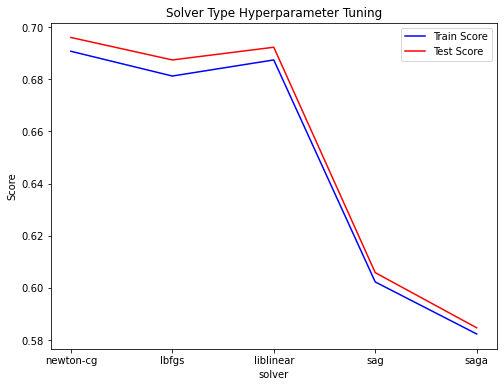

In [27]:
def logreg(X_train,X_test,y_train,y_test,solver):
    
    result = []
    
    for param in solver:
        clf = LogisticRegression(solver= param, max_iter = 100)
        model = clf.fit(X_train, y_train)
        result.append([param, model.score(X_train,y_train), model.score(X_test,y_test)])
        
    result = pd.DataFrame(result,columns=["solver","train_score","test_score"])
        
    return result

#Performing parameter search
logreg_pred = logreg(X_train,X_test,y_train,y_test,["newton-cg", "lbfgs", "liblinear", "sag", "saga"])

#Plotting the curves for train score and test score against the solver type of logistic regression
f, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(logreg_pred["solver"], logreg_pred["train_score"], color="blue")   #train score
ax.plot(logreg_pred["solver"], logreg_pred["test_score"], color ="red")   #test score
ax.set_title('Solver Type Hyperparameter Tuning')
ax.set_xlabel("solver")
ax.set_ylabel("Score")
ax.legend(["Train Score","Test Score"])


Newton-cg solver worked best. For this logistic regression model, there are only a few parameters to tune. One can tune the class weights too, but since the scores are about similar to random forest model, I decided not to tune it.

In [28]:
#Assigning the parameters into the final model
clf = LogisticRegression(solver= 'newton-cg', max_iter = 100)
model_lr = clf.fit(X_train, y_train)
print("Train score:",model_lr.score(X_train,y_train))
print("Test score:",model_lr.score(X_test,y_test))

C:\Users\MIKE\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\MIKE\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Train score: 0.690704105509466
Test score: 0.6959955328653478


#### ii. Confusion Matrix and F1 Scoring

<AxesSubplot:>

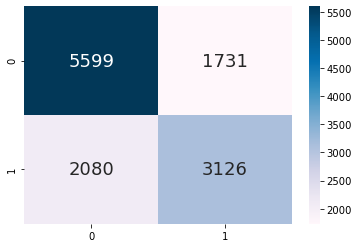

In [29]:
y_test_pred = model_lr.predict(X_test)

sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},cmap = "PuBu")

In [30]:
f1_score(y_test,y_test_pred,average='weighted')

0.6942583310347273

In [31]:
#Saving our model
pickle.dump(model_lr, open("logreg_model.sav",'wb'))

model_result.append(["Logreg",model_lr.score(X_train,y_train),model_lr.score(X_test,y_test),\
                     f1_score(y_test,y_test_pred,average="weighted")])

### 3. Neural Network using TensorFlow

In [32]:
#pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

**Disclaimer:** Since I lack the knowledge of unsupervised learning, in this project we will go through a sample neural network model without going deeply into the hyperparameter tuning parts. 

#### i. Creating the Neural Network Model

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((X_train.values,y_train.values))

train_dataset = dataset.batch(256)

Defining the optimizers.

In [34]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

Defining the model with 2 hidden layers with 'relu' activation function.

In [35]:
model = keras.Sequential([
    keras.layers.Dense(100,activation = 'relu'),
    keras.layers.Dense(50,activation = 'relu'),
    keras.layers.Dense(1,activation = 'sigmoid', activity_regularizer = regularizers.l1(0.01))
])

model.compile(
    optimizer = Adam,
    loss = "binary_crossentropy",
    metrics = ['acc']
)

#### ii. Fitting and evaluating the Neural Network Model

In [36]:
model.fit(train_dataset,epochs = 2000, verbose = 2)

Epoch 1/2000
147/147 - 1s - loss: 2.8758 - acc: 0.5516
Epoch 2/2000
147/147 - 0s - loss: 0.7820 - acc: 0.5672
Epoch 3/2000
147/147 - 0s - loss: 0.6743 - acc: 0.6192
Epoch 4/2000
147/147 - 0s - loss: 0.6882 - acc: 0.6226
Epoch 5/2000
147/147 - 0s - loss: 0.8667 - acc: 0.6084
Epoch 6/2000
147/147 - 0s - loss: 0.6444 - acc: 0.6488
Epoch 7/2000
147/147 - 0s - loss: 0.6766 - acc: 0.6337
Epoch 8/2000
147/147 - 0s - loss: 0.6432 - acc: 0.6508
Epoch 9/2000
147/147 - 0s - loss: 0.6535 - acc: 0.6477
Epoch 10/2000
147/147 - 0s - loss: 0.6579 - acc: 0.6469
Epoch 11/2000
147/147 - 0s - loss: 0.6592 - acc: 0.6473
Epoch 12/2000
147/147 - 0s - loss: 0.6594 - acc: 0.6487
Epoch 13/2000
147/147 - 0s - loss: 0.6591 - acc: 0.6495
Epoch 14/2000
147/147 - 0s - loss: 0.6584 - acc: 0.6503
Epoch 15/2000
147/147 - 0s - loss: 0.6576 - acc: 0.6510
Epoch 16/2000
147/147 - 0s - loss: 0.6567 - acc: 0.6519
Epoch 17/2000
147/147 - 0s - loss: 0.6555 - acc: 0.6527
Epoch 18/2000
147/147 - 0s - loss: 0.6543 - acc: 0.6536
E

Epoch 147/2000
147/147 - 0s - loss: 0.5894 - acc: 0.6757
Epoch 148/2000
147/147 - 0s - loss: 0.5893 - acc: 0.6759
Epoch 149/2000
147/147 - 0s - loss: 0.5891 - acc: 0.6760
Epoch 150/2000
147/147 - 0s - loss: 0.5889 - acc: 0.6758
Epoch 151/2000
147/147 - 0s - loss: 0.5888 - acc: 0.6758
Epoch 152/2000
147/147 - 0s - loss: 0.5886 - acc: 0.6759
Epoch 153/2000
147/147 - 0s - loss: 0.5885 - acc: 0.6760
Epoch 154/2000
147/147 - 0s - loss: 0.5883 - acc: 0.6764
Epoch 155/2000
147/147 - 0s - loss: 0.5882 - acc: 0.6762
Epoch 156/2000
147/147 - 0s - loss: 0.5880 - acc: 0.6768
Epoch 157/2000
147/147 - 0s - loss: 0.5878 - acc: 0.6769
Epoch 158/2000
147/147 - 0s - loss: 0.5877 - acc: 0.6769
Epoch 159/2000
147/147 - 0s - loss: 0.5876 - acc: 0.6772
Epoch 160/2000
147/147 - 0s - loss: 0.5874 - acc: 0.6773
Epoch 161/2000
147/147 - 0s - loss: 0.5873 - acc: 0.6775
Epoch 162/2000
147/147 - 0s - loss: 0.5871 - acc: 0.6775
Epoch 163/2000
147/147 - 0s - loss: 0.5870 - acc: 0.6778
Epoch 164/2000
147/147 - 0s - l

Epoch 291/2000
147/147 - 0s - loss: 0.5749 - acc: 0.6846
Epoch 292/2000
147/147 - 0s - loss: 0.5752 - acc: 0.6852
Epoch 293/2000
147/147 - 0s - loss: 0.5745 - acc: 0.6858
Epoch 294/2000
147/147 - 0s - loss: 0.5747 - acc: 0.6855
Epoch 295/2000
147/147 - 0s - loss: 0.5747 - acc: 0.6851
Epoch 296/2000
147/147 - 0s - loss: 0.5747 - acc: 0.6857
Epoch 297/2000
147/147 - 0s - loss: 0.5746 - acc: 0.6864
Epoch 298/2000
147/147 - 0s - loss: 0.5747 - acc: 0.6858
Epoch 299/2000
147/147 - 0s - loss: 0.5744 - acc: 0.6860
Epoch 300/2000
147/147 - 0s - loss: 0.5743 - acc: 0.6863
Epoch 301/2000
147/147 - 0s - loss: 0.5742 - acc: 0.6859
Epoch 302/2000
147/147 - 0s - loss: 0.5741 - acc: 0.6863
Epoch 303/2000
147/147 - 0s - loss: 0.5743 - acc: 0.6861
Epoch 304/2000
147/147 - 0s - loss: 0.5742 - acc: 0.6863
Epoch 305/2000
147/147 - 0s - loss: 0.5742 - acc: 0.6863
Epoch 306/2000
147/147 - 0s - loss: 0.5742 - acc: 0.6864
Epoch 307/2000
147/147 - 0s - loss: 0.5741 - acc: 0.6869
Epoch 308/2000
147/147 - 0s - l

Epoch 435/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6889
Epoch 436/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6892
Epoch 437/2000
147/147 - 0s - loss: 0.5721 - acc: 0.6892
Epoch 438/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6894
Epoch 439/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6890
Epoch 440/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6897
Epoch 441/2000
147/147 - 0s - loss: 0.5721 - acc: 0.6891
Epoch 442/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6893
Epoch 443/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6893
Epoch 444/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6897
Epoch 445/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6892
Epoch 446/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6894
Epoch 447/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6892
Epoch 448/2000
147/147 - 0s - loss: 0.5717 - acc: 0.6899
Epoch 449/2000
147/147 - 0s - loss: 0.5720 - acc: 0.6895
Epoch 450/2000
147/147 - 0s - loss: 0.5719 - acc: 0.6896
Epoch 451/2000
147/147 - 0s - loss: 0.5718 - acc: 0.6902
Epoch 452/2000
147/147 - 0s - l

Epoch 579/2000
147/147 - 0s - loss: 0.5714 - acc: 0.6895
Epoch 580/2000
147/147 - 0s - loss: 0.5715 - acc: 0.6895
Epoch 581/2000
147/147 - 0s - loss: 0.5717 - acc: 0.6890
Epoch 582/2000
147/147 - 0s - loss: 0.5714 - acc: 0.6899
Epoch 583/2000
147/147 - 0s - loss: 0.5715 - acc: 0.6892
Epoch 584/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6892
Epoch 585/2000
147/147 - 0s - loss: 0.5714 - acc: 0.6883
Epoch 586/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6886
Epoch 587/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6887
Epoch 588/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6881
Epoch 589/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6883
Epoch 590/2000
147/147 - 0s - loss: 0.5715 - acc: 0.6886
Epoch 591/2000
147/147 - 0s - loss: 0.5714 - acc: 0.6883
Epoch 592/2000
147/147 - 0s - loss: 0.5716 - acc: 0.6881
Epoch 593/2000
147/147 - 0s - loss: 0.5713 - acc: 0.6872
Epoch 594/2000
147/147 - 0s - loss: 0.5717 - acc: 0.6881
Epoch 595/2000
147/147 - 0s - loss: 0.5714 - acc: 0.6880
Epoch 596/2000
147/147 - 0s - l

Epoch 723/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6897
Epoch 724/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6895
Epoch 725/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6893
Epoch 726/2000
147/147 - 0s - loss: 0.5700 - acc: 0.6889
Epoch 727/2000
147/147 - 0s - loss: 0.5701 - acc: 0.6893
Epoch 728/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6894
Epoch 729/2000
147/147 - 0s - loss: 0.5700 - acc: 0.6897
Epoch 730/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6902
Epoch 731/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6897
Epoch 732/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6902
Epoch 733/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6903
Epoch 734/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6900
Epoch 735/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6900
Epoch 736/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6899
Epoch 737/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6901
Epoch 738/2000
147/147 - 0s - loss: 0.5699 - acc: 0.6902
Epoch 739/2000
147/147 - 0s - loss: 0.5698 - acc: 0.6900
Epoch 740/2000
147/147 - 0s - l

Epoch 867/2000
147/147 - 0s - loss: 0.5686 - acc: 0.6897
Epoch 868/2000
147/147 - 0s - loss: 0.5686 - acc: 0.6899
Epoch 869/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6903
Epoch 870/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6901
Epoch 871/2000
147/147 - 0s - loss: 0.5686 - acc: 0.6903
Epoch 872/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6901
Epoch 873/2000
147/147 - 0s - loss: 0.5687 - acc: 0.6894
Epoch 874/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6898
Epoch 875/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6901
Epoch 876/2000
147/147 - 0s - loss: 0.5686 - acc: 0.6902
Epoch 877/2000
147/147 - 0s - loss: 0.5687 - acc: 0.6903
Epoch 878/2000
147/147 - 0s - loss: 0.5685 - acc: 0.6902
Epoch 879/2000
147/147 - 0s - loss: 0.5686 - acc: 0.6899
Epoch 880/2000
147/147 - 0s - loss: 0.5684 - acc: 0.6909
Epoch 881/2000
147/147 - 0s - loss: 0.5684 - acc: 0.6904
Epoch 882/2000
147/147 - 0s - loss: 0.5684 - acc: 0.6899
Epoch 883/2000
147/147 - 0s - loss: 0.5684 - acc: 0.6906
Epoch 884/2000
147/147 - 0s - l

Epoch 1011/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6927
Epoch 1012/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6922
Epoch 1013/2000
147/147 - 0s - loss: 0.5675 - acc: 0.6924
Epoch 1014/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6922
Epoch 1015/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6913
Epoch 1016/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6919
Epoch 1017/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6921
Epoch 1018/2000
147/147 - 0s - loss: 0.5678 - acc: 0.6919
Epoch 1019/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6924
Epoch 1020/2000
147/147 - 0s - loss: 0.5677 - acc: 0.6913
Epoch 1021/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6916
Epoch 1022/2000
147/147 - 0s - loss: 0.5674 - acc: 0.6922
Epoch 1023/2000
147/147 - 0s - loss: 0.5679 - acc: 0.6916
Epoch 1024/2000
147/147 - 0s - loss: 0.5680 - acc: 0.6916
Epoch 1025/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6913
Epoch 1026/2000
147/147 - 0s - loss: 0.5676 - acc: 0.6923
Epoch 1027/2000
147/147 - 0s - loss: 0.5677 - acc: 0.6918
Epoch 1028/200

147/147 - 0s - loss: 0.5665 - acc: 0.6930
Epoch 1153/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6926
Epoch 1154/2000
147/147 - 0s - loss: 0.5665 - acc: 0.6929
Epoch 1155/2000
147/147 - 0s - loss: 0.5666 - acc: 0.6928
Epoch 1156/2000
147/147 - 0s - loss: 0.5668 - acc: 0.6920
Epoch 1157/2000
147/147 - 0s - loss: 0.5663 - acc: 0.6928
Epoch 1158/2000
147/147 - 0s - loss: 0.5672 - acc: 0.6918
Epoch 1159/2000
147/147 - 0s - loss: 0.5670 - acc: 0.6933
Epoch 1160/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6927
Epoch 1161/2000
147/147 - 0s - loss: 0.5666 - acc: 0.6935
Epoch 1162/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6934
Epoch 1163/2000
147/147 - 0s - loss: 0.5670 - acc: 0.6918
Epoch 1164/2000
147/147 - 0s - loss: 0.5661 - acc: 0.6930
Epoch 1165/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6931
Epoch 1166/2000
147/147 - 0s - loss: 0.5666 - acc: 0.6934
Epoch 1167/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6933
Epoch 1168/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6924
Epoch 1169/2000
147/147 - 0s -

Epoch 1294/2000
147/147 - 0s - loss: 0.5661 - acc: 0.6941
Epoch 1295/2000
147/147 - 0s - loss: 0.5661 - acc: 0.6935
Epoch 1296/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6941
Epoch 1297/2000
147/147 - 0s - loss: 0.5657 - acc: 0.6946
Epoch 1298/2000
147/147 - 0s - loss: 0.5654 - acc: 0.6945
Epoch 1299/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6937
Epoch 1300/2000
147/147 - 0s - loss: 0.5659 - acc: 0.6949
Epoch 1301/2000
147/147 - 0s - loss: 0.5657 - acc: 0.6944
Epoch 1302/2000
147/147 - 0s - loss: 0.5662 - acc: 0.6933
Epoch 1303/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6934
Epoch 1304/2000
147/147 - 0s - loss: 0.5660 - acc: 0.6934
Epoch 1305/2000
147/147 - 0s - loss: 0.5661 - acc: 0.6936
Epoch 1306/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6942
Epoch 1307/2000
147/147 - 0s - loss: 0.5660 - acc: 0.6938
Epoch 1308/2000
147/147 - 0s - loss: 0.5657 - acc: 0.6940
Epoch 1309/2000
147/147 - 0s - loss: 0.5660 - acc: 0.6941
Epoch 1310/2000
147/147 - 0s - loss: 0.5661 - acc: 0.6925
Epoch 1311/200

147/147 - 0s - loss: 0.5653 - acc: 0.6964
Epoch 1436/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6966
Epoch 1437/2000
147/147 - 0s - loss: 0.5652 - acc: 0.6958
Epoch 1438/2000
147/147 - 0s - loss: 0.5650 - acc: 0.6952
Epoch 1439/2000
147/147 - 0s - loss: 0.5652 - acc: 0.6962
Epoch 1440/2000
147/147 - 0s - loss: 0.5650 - acc: 0.6955
Epoch 1441/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6959
Epoch 1442/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6957
Epoch 1443/2000
147/147 - 0s - loss: 0.5657 - acc: 0.6947
Epoch 1444/2000
147/147 - 0s - loss: 0.5647 - acc: 0.6966
Epoch 1445/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6964
Epoch 1446/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6958
Epoch 1447/2000
147/147 - 0s - loss: 0.5649 - acc: 0.6967
Epoch 1448/2000
147/147 - 0s - loss: 0.5659 - acc: 0.6950
Epoch 1449/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6971
Epoch 1450/2000
147/147 - 0s - loss: 0.5646 - acc: 0.6972
Epoch 1451/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6974
Epoch 1452/2000
147/147 - 0s -

Epoch 1577/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6974
Epoch 1578/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6969
Epoch 1579/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6958
Epoch 1580/2000
147/147 - 0s - loss: 0.5657 - acc: 0.6959
Epoch 1581/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6954
Epoch 1582/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6962
Epoch 1583/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6970
Epoch 1584/2000
147/147 - 0s - loss: 0.5659 - acc: 0.6949
Epoch 1585/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6971
Epoch 1586/2000
147/147 - 0s - loss: 0.5654 - acc: 0.6963
Epoch 1587/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6960
Epoch 1588/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6964
Epoch 1589/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6955
Epoch 1590/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6968
Epoch 1591/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6964
Epoch 1592/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6964
Epoch 1593/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6979
Epoch 1594/200

147/147 - 0s - loss: 0.5651 - acc: 0.6963
Epoch 1719/2000
147/147 - 0s - loss: 0.5645 - acc: 0.6971
Epoch 1720/2000
147/147 - 0s - loss: 0.5649 - acc: 0.6961
Epoch 1721/2000
147/147 - 0s - loss: 0.5649 - acc: 0.6967
Epoch 1722/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6960
Epoch 1723/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6948
Epoch 1724/2000
147/147 - 0s - loss: 0.5658 - acc: 0.6947
Epoch 1725/2000
147/147 - 0s - loss: 0.5650 - acc: 0.6966
Epoch 1726/2000
147/147 - 0s - loss: 0.5666 - acc: 0.6951
Epoch 1727/2000
147/147 - 0s - loss: 0.5644 - acc: 0.6960
Epoch 1728/2000
147/147 - 0s - loss: 0.5649 - acc: 0.6963
Epoch 1729/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6954
Epoch 1730/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6948
Epoch 1731/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6954
Epoch 1732/2000
147/147 - 0s - loss: 0.5658 - acc: 0.6961
Epoch 1733/2000
147/147 - 0s - loss: 0.5646 - acc: 0.6962
Epoch 1734/2000
147/147 - 0s - loss: 0.5647 - acc: 0.6978
Epoch 1735/2000
147/147 - 0s -

Epoch 1860/2000
147/147 - 0s - loss: 0.5647 - acc: 0.6948
Epoch 1861/2000
147/147 - 0s - loss: 0.5649 - acc: 0.6957
Epoch 1862/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6957
Epoch 1863/2000
147/147 - 0s - loss: 0.5664 - acc: 0.6958
Epoch 1864/2000
147/147 - 0s - loss: 0.5655 - acc: 0.6974
Epoch 1865/2000
147/147 - 0s - loss: 0.5651 - acc: 0.6963
Epoch 1866/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6967
Epoch 1867/2000
147/147 - 0s - loss: 0.5650 - acc: 0.6958
Epoch 1868/2000
147/147 - 0s - loss: 0.5660 - acc: 0.6947
Epoch 1869/2000
147/147 - 0s - loss: 0.5652 - acc: 0.6966
Epoch 1870/2000
147/147 - 0s - loss: 0.5654 - acc: 0.6958
Epoch 1871/2000
147/147 - 0s - loss: 0.5645 - acc: 0.6964
Epoch 1872/2000
147/147 - 0s - loss: 0.5654 - acc: 0.6952
Epoch 1873/2000
147/147 - 0s - loss: 0.5656 - acc: 0.6958
Epoch 1874/2000
147/147 - 0s - loss: 0.5654 - acc: 0.6947
Epoch 1875/2000
147/147 - 0s - loss: 0.5648 - acc: 0.6953
Epoch 1876/2000
147/147 - 0s - loss: 0.5653 - acc: 0.6946
Epoch 1877/200

In [37]:
print("Train score:",model.evaluate(X_train.values,y_train.values)[1])
print("Test score:",model.evaluate(X_test.values,y_test.values)[1])

1176/1176 [==============================] - 1s 852us/step - loss: 0.5650 - acc: 0.6937
Train score: 0.6937353610992432
392/392 [==============================] - 0s 888us/step - loss: 0.5564 - acc: 0.6975
Test score: 0.6975111961364746


#### iii. Confusion Matrix and F1 Scoring

<AxesSubplot:>

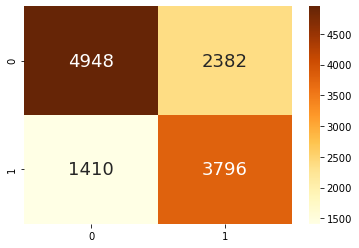

In [38]:
y_test_pred = model.predict(X_test)

y_test_pred_ = []

for y in y_test_pred:
    if y[0] > 0.5:
        y_test_pred_.append(1)
    else:
        y_test_pred_.append(0)

sb.heatmap(confusion_matrix(y_test, y_test_pred_), 
           annot = True, fmt=".0f", annot_kws={"size": 18},cmap = "YlOrBr")

In [39]:
f1_score(y_test,y_test_pred_,average='weighted')

0.6996848358052213

In [40]:
#Saving our model
model.save("neural_network_model.h5")

model_result.append(["Neural_Network",model.evaluate(X_train.values,y_train.values)[1], \
                     model.evaluate(X_test.values,y_test.values)[1], \
                     f1_score(y_test,y_test_pred_,average="weighted")])

392/392 [==============================] - 0s 872us/step - loss: 0.5564 - acc: 0.6975


**From the three models we've created here are the summary of performance:**

In [41]:
model_result_df = pd.DataFrame(model_result,columns=["Model","Train Score","Test Score","F1 Score"])
model_result_df

,Model,Train Score,Test Score,F1 Score
0,RFC,0.724739,0.699107,0.696568
1,Logreg,0.690704,0.695996,0.694258
2,Neural_Network,0.693735,0.697511,0.699685


## The End